In [1]:
import pandas as pd
from datasets import Dataset, load_metric
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, get_scheduler
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import dill

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
#torch.manual_seed(1)

cuda


In [3]:
df_train = pd.read_csv('./train.tsv', sep='\t', names=['text', 'Domain'])
df_train.head()

,text,Domain
0,the quality of being beneficial and generally ...,Philosophy and psychology
1,insure again by transferring to another insura...,"Business, economics, and finance"
2,foolish gibberish,Language and linguistics
3,the property of being a relatively small amoun...,Mathematics
4,an arrangement of a piece of music for perform...,Music


In [4]:
df_test = pd.read_csv('./test.tsv', sep='\t', names=['text', 'Domain'])
df_test.head()

,text,Domain
0,(physics) statistical law obeyed by a system o...,Physics and astronomy
1,(physics) the process in which incident radiat...,Physics and astronomy
2,(physics) the exponential return of a system t...,Physics and astronomy
3,(physics) a coefficient that expresses how muc...,Physics and astronomy
4,(physics) the point of minimum displacement in...,Physics and astronomy


In [4]:
# df_train.Domain.value_counts().plot(kind='pie', figsize=(8,8), title="Train partition", ylabel='')

In [5]:
# df_test.Domain.value_counts().plot(kind='pie', figsize=(8,8), title="Test partition", ylabel='')

In [5]:
label2id = {}

def encode_domain(x):
    if x not in label2id.keys():
        label2id[x]=len(label2id)
    return label2id[x]

df_train['labels'] = df_train['Domain'].apply(lambda x: encode_domain(x))
assert df_train['labels'].max() == 33, "The maximum encoded category should be 33" #Hay 34 clases en total
df_train = df_train.drop(columns='Domain')
df_train.head()

,text,labels
0,the quality of being beneficial and generally ...,0
1,insure again by transferring to another insura...,1
2,foolish gibberish,2
3,the property of being a relatively small amoun...,3
4,an arrangement of a piece of music for perform...,4


In [6]:
df_test['labels'] = df_test['Domain'].apply(lambda x: encode_domain(x))
assert df_test['labels'].max() == 33, "The maximum encoded category should be 33" #Hay 34 clases en total
df_test = df_test.drop(columns='Domain')
df_test.head()

,text,labels
0,(physics) statistical law obeyed by a system o...,14
1,(physics) the process in which incident radiat...,14
2,(physics) the exponential return of a system t...,14
3,(physics) a coefficient that expresses how muc...,14
4,(physics) the point of minimum displacement in...,14


In [7]:
id2label = {index: label for label, index in label2id.items()}
print(id2label)

{0: 'Philosophy and psychology', 1: 'Business, economics, and finance', 2: 'Language and linguistics', 3: 'Mathematics', 4: 'Music', 5: 'Animals', 6: 'Warfare and defense', 7: 'Literature and theatre', 8: 'Numismatics and currencies', 9: 'Religion, mysticism and mythology', 10: 'Biology', 11: 'Media', 12: 'Geography and places', 13: 'Education', 14: 'Physics and astronomy', 15: 'Health and medicine', 16: 'Heraldry, honors, and vexillology', 17: 'Engineering and technology', 18: 'Chemistry and mineralogy', 19: 'Law and crime', 20: 'Computing', 21: 'Art, architecture, and archaeology', 22: 'Food and drink', 23: 'Textile and clothing', 24: 'Sport and recreation', 25: 'Transport and travel', 26: 'Geology and geophysics', 27: 'Farming', 28: 'Politics and government', 29: 'Meteorology', 30: 'Royalty and nobility', 31: 'Culture and society', 32: 'Games and video games', 33: 'History'}


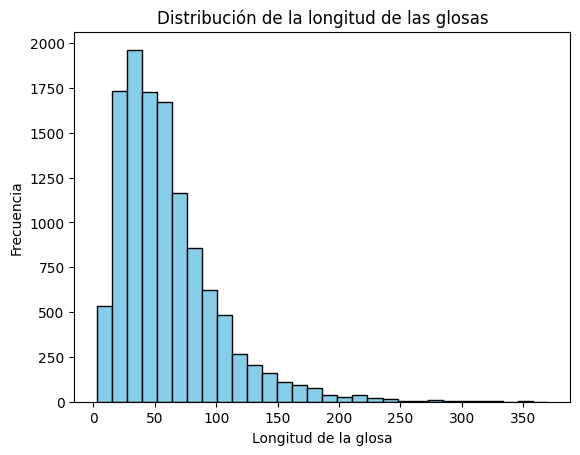

In [10]:
longitudes = df_train['text'].apply(len)

# Crear el histograma usando el método plot de pandas
longitudes.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')

# Configurar el título y etiquetas de los ejes
plt.title('Distribución de la longitud de las glosas')
plt.xlabel('Longitud de la glosa')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

Vamos a crear la partición de validación y ya podemos crear los tres Datasets

In [11]:
train_size = 0.85
train=df_train.sample(frac=train_size,random_state=200).reset_index(drop=True)
valid=df_train.drop(train.index).reset_index(drop=True)
train_dataset = Dataset.from_pandas(train)
valid_dataset = Dataset.from_pandas(valid)
test_dataset = Dataset.from_pandas(df_test)

## Búsqueda de hiperparametros

In [12]:
model_ckpt='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)

In [13]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_valid = tokenized_valid.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=32, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/10072 [00:00<?, ? examples/s]

Map:   0%|          | 0/1777 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [47]:
num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 6
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [12]:
metric = load_metric("accuracy")

/tmp/ipykernel_79063/2588679507.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [48]:

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    if epoch ==4:
        torch.save(model, "./Pretrained/distilbertEpoch4Tasa5e-5")
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        if (batch_num + 1) % 50 == 0:
            model.eval()  # Establecer el modelo en modo de evaluación
            val_loss = 0.0

            with torch.no_grad():
                for val_batch in valid_dataloader:
                    val_batch = {k: v.to(device) for k, v in val_batch.items()}
                    val_outputs = model(**val_batch)
                    val_loss += val_outputs.loss.item()
                    logits = val_outputs.logits
                    predictions = torch.argmax(logits, dim=-1)
                    metric.add_batch(predictions=predictions, references=val_batch["labels"])

                val_acc = metric.compute()['accuracy']


            # Calcular la pérdida de validación promedio
            avg_val_loss = val_loss / len(valid_dataloader)

            # Guardar los valores de pérdida
            train_losses.append(train_loss / 50)
            valid_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Iteration {batch_num + 1}, Training Loss: {train_loss / 50:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
            train_loss=0.0



  0%|          | 0/1890 [00:00<?, ?it/s]

Epoch 1, Iteration 50, Training Loss: 0.6644, Validation Loss: 1.9459, Validation Accuracy: 0.6089
Epoch 1, Iteration 100, Training Loss: 0.3834, Validation Loss: 1.1575, Validation Accuracy: 0.7580
Epoch 1, Iteration 150, Training Loss: 0.2491, Validation Loss: 0.8478, Validation Accuracy: 0.8120
Epoch 1, Iteration 200, Training Loss: 0.2133, Validation Loss: 0.6764, Validation Accuracy: 0.8514
Epoch 1, Iteration 250, Training Loss: 0.1822, Validation Loss: 0.5822, Validation Accuracy: 0.8633
Epoch 1, Iteration 300, Training Loss: 0.1715, Validation Loss: 0.5156, Validation Accuracy: 0.8779
Epoch 2, Iteration 50, Training Loss: 0.1180, Validation Loss: 0.4292, Validation Accuracy: 0.8959
Epoch 2, Iteration 100, Training Loss: 0.0933, Validation Loss: 0.3751, Validation Accuracy: 0.9077
Epoch 2, Iteration 150, Training Loss: 0.0959, Validation Loss: 0.3721, Validation Accuracy: 0.9105
Epoch 2, Iteration 200, Training Loss: 0.0926, Validation Loss: 0.3130, Validation Accuracy: 0.9291
Ep

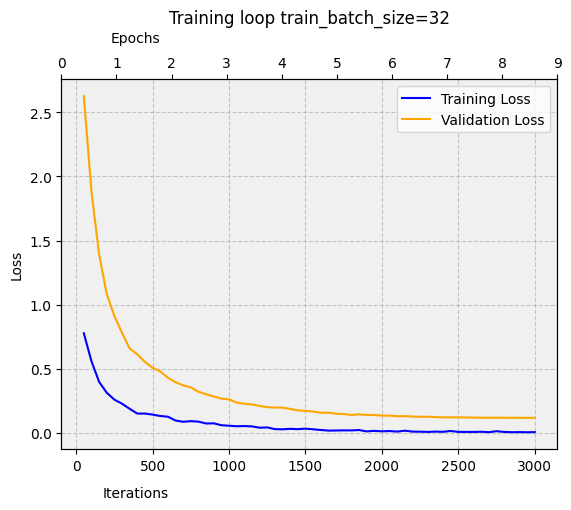

In [22]:
iterations_x = np.arange(1, len(train_losses) + 1) * 50  # Crea un array de valores para cada 200 iteraciones

epochs_x = np.arange(0, num_epochs)  # Crea un array de valores para las épocas

fig, ax1 = plt.subplots()

ax1.plot(iterations_x, train_losses, label='Training Loss', color='blue')
ax1.plot(iterations_x, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color='black')
ax1.legend(loc='upper right')
ax1.xaxis.set_label_coords(0.15, -0.1)

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_facecolor('#f0f0f0')

# Crear un segundo eje x para las épocas
ax2 = ax1.twiny()
ax2.set_xticks(epochs_x)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss', color='black') 
ax2.xaxis.set_label_coords(0.15, 1.1)
title = ax1.set_title("Training loop train_batch_size=32")
title.set_y(2)


plt.show()

In [20]:

def compute_metrics(preds, labels):

    # Obtain predicted class labels by finding the column index with the maximum probability

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary

    return {
    'Accuracy': acc,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
    }


In [26]:
model = torch.load("./Pretrained/distilbertEpoch6Tasa5e-5WarmCos")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

{'Accuracy': 0.8792207792207792, 'F1': 0.8764749040816545, 'Precision': 0.8909582435735336, 'Recall': 0.8792207792207792}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
torch.save(model, "./Pretrained/distilbertEpoch6Tasa8e-5WarmCos")

##### TrainFull

In [27]:
trainfull_dataset = Dataset.from_pandas(df_train)
tokenizedfull_train = trainfull_dataset.map(preprocess_function, batched=True)
tokenizedfull_train = tokenizedfull_train.remove_columns(["text"])

tokenizedfull_train.set_format("torch")
trainfull_dataloader = DataLoader(tokenizedfull_train, batch_size=32, shuffle=True, collate_fn=data_collator)

Map:   0%|          | 0/11849 [00:00<?, ? examples/s]

In [28]:
num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 6
num_training_steps = num_epochs * len(trainfull_dataloader)
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [29]:
progress_bar = tqdm(range(num_training_steps))
train_loss=0.0
model.train()
for epoch in range(num_epochs):    
    for batch_num, batch in enumerate(trainfull_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        train_loss += loss.item()
        if batch_num%200==0:
            print(train_loss/200)
            train_loss=0.0



  0%|          | 0/1484 [00:00<?, ?it/s]

0.017824230194091798
2.0305729013681413
0.6258384090662003
0.4471934324130416
0.33715564765036105
0.21126779564656317
0.18925811927765607
0.14559029729105533


In [30]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

{'Accuracy': 0.8642857142857143, 'F1': 0.8607892204010892, 'Precision': 0.8788055107608939, 'Recall': 0.8642857142857143}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
print(len(trainfull_dataloader)*32)

11872


## Probando otros modelos
#### Bert-Base

In [16]:
model_ckpt='bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_valid = tokenized_valid.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=32, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)


Map:   0%|          | 0/10072 [00:00<?, ? examples/s]

Map:   0%|          | 0/1777 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [12]:

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

num_epochs = 4
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)

model.to(device)

    
    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        if (batch_num + 1) % 50 == 0:
            model.eval()  # Establecer el modelo en modo de evaluación
            val_loss = 0.0

            with torch.no_grad():
                for val_batch in test_dataloader:
                    val_batch = {k: v.to(device) for k, v in val_batch.items()}
                    val_outputs = model(**val_batch)
                    val_loss += val_outputs.loss.item()
                    logits = val_outputs.logits
                    predictions = torch.argmax(logits, dim=-1)
                    metric.add_batch(predictions=predictions, references=val_batch["labels"])

                val_acc = metric.compute()['accuracy']


            # Calcular la pérdida de validación promedio
            avg_val_loss = val_loss / len(valid_dataloader)

            # Guardar los valores de pérdida
            train_losses.append(train_loss / 50)
            valid_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Iteration {batch_num + 1}, Training Loss: {train_loss / 50:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
            train_loss=0.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [23]:

model = torch.load("./Pretrained/bertEpoch4Tasa5e-5CosineWarm100")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)
print(metrics)


{'Accuracy': 0.8525974025974026, 'F1': 0.8555950315333186, 'Precision': 0.8800199189790212, 'Recall': 0.8525974025974026}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
torch.save(model, "./Pretrained/bertEpoch4Tasa3e-5LinealWarm100")

##### TrainFull

In [17]:
model_ckpt = "bert-base-uncased"
trainfull_dataset = Dataset.from_pandas(df_train)
tokenizedfull_train = trainfull_dataset.map(preprocess_function, batched=True)
tokenizedfull_train = tokenizedfull_train.remove_columns(["text"])

tokenizedfull_train.set_format("torch")
trainfull_dataloader = DataLoader(tokenizedfull_train, batch_size=32, shuffle=True, collate_fn=data_collator)

Map:   0%|          | 0/11849 [00:00<?, ? examples/s]

In [18]:

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 4
num_training_steps = num_epochs * len(trainfull_dataloader)
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)
model.to(device)
progress_bar = tqdm(range(num_training_steps))
train_loss=0.0
model.train()
for epoch in range(num_epochs):    
    for batch_num, batch in enumerate(trainfull_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        train_loss += loss.item()
        if (batch_num+1)%200==0:
            print(train_loss/200)
            train_loss=0.0



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1484 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


0.01781702518463135
1.9852690252661704
0.693440227508545
0.47142112378031015
0.35483070092275737
0.23915977058932186
0.16609195677563549
0.14207945662550628


In [19]:

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

NameError: name 'compute_metrics' is not defined

#### Roberta

In [22]:
model_ckpt='roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_valid = tokenized_valid.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=32, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(tokenized_valid, batch_size=64, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)


Map:   0%|          | 0/10072 [00:00<?, ? examples/s]

Map:   0%|          | 0/1777 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [36]:

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 6 ##Hyperparameter
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)

model.to(device)

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    if epoch==4:
        torch.save(model, "robertaEpoch4Tasa5e-5CosineWarm")
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()
        if (batch_num + 1) % 50 == 0:
            model.eval()  # Establecer el modelo en modo de evaluación
            val_loss = 0.0

            with torch.no_grad():
                for val_batch in valid_dataloader:
                    val_batch = {k: v.to(device) for k, v in val_batch.items()}
                    val_outputs = model(**val_batch)
                    val_loss += val_outputs.loss.item()
                    logits = val_outputs.logits
                    predictions = torch.argmax(logits, dim=-1)
                    metric.add_batch(predictions=predictions, references=val_batch["labels"])

                val_acc = metric.compute()['accuracy']


            # Calcular la pérdida de validación promedio
            avg_val_loss = val_loss / len(valid_dataloader)

            # Guardar los valores de pérdida
            train_losses.append(train_loss / 50)
            valid_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Iteration {batch_num + 1}, Training Loss: {train_loss / 50:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
            train_loss=0.0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1890 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1, Iteration 50, Training Loss: 3.2331, Validation Loss: 2.6914, Validation Accuracy: 0.2645
Epoch 1, Iteration 100, Training Loss: 1.9133, Validation Loss: 1.2353, Validation Accuracy: 0.7349
Epoch 1, Iteration 150, Training Loss: 1.0843, Validation Loss: 0.8515, Validation Accuracy: 0.8109
Epoch 1, Iteration 200, Training Loss: 0.8959, Validation Loss: 0.7820, Validation Accuracy: 0.8177
Epoch 1, Iteration 250, Training Loss: 0.8245, Validation Loss: 0.6621, Validation Accuracy: 0.8374
Epoch 1, Iteration 300, Training Loss: 0.7084, Validation Loss: 0.5507, Validation Accuracy: 0.8672
Epoch 2, Iteration 50, Training Loss: 0.5877, Validation Loss: 0.4721, Validation Accuracy: 0.8869
Epoch 2, Iteration 100, Training Loss: 0.4483, Validation Loss: 0.4534, Validation Accuracy: 0.8807
Epoch 2, Iteration 150, Training Loss: 0.4526, Validation Loss: 0.4044, Validation Accuracy: 0.9010
Epoch 2, Iteration 200, Training Loss: 0.4509, Validation Loss: 0.3562, Validation Accuracy: 0.9128
Ep

In [26]:


model = torch.load("./Pretrained/robertaEpoch6Tasa5e-5CosineWarm")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)
print(metrics)


{'Accuracy': 0.8467532467532467, 'F1': 0.8482724013352022, 'Precision': 0.8690815985370052, 'Recall': 0.8467532467532467}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:


#torch.save(model, "./Pretrained/robertaEpoch6Tasa5e-5CosineWarm")

##### TrainFull

In [23]:
model_ckpt = "roberta-base"
trainfull_dataset = Dataset.from_pandas(df_train)
tokenizedfull_train = trainfull_dataset.map(preprocess_function, batched=True)
tokenizedfull_train = tokenizedfull_train.remove_columns(["text"])

tokenizedfull_train.set_format("torch")
trainfull_dataloader = DataLoader(tokenizedfull_train, batch_size=32, shuffle=True, collate_fn=data_collator)


Map:   0%|          | 0/11849 [00:00<?, ? examples/s]

In [24]:

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_epochs = 6
num_training_steps = num_epochs * len(trainfull_dataloader)
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)
model.to(device)
progress_bar = tqdm(range(num_training_steps))
train_loss=0.0
model.train()
for epoch in range(num_epochs):    
    for batch_num, batch in enumerate(trainfull_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        train_loss += loss.item()
        if (batch_num+1)%200==0:
            print(train_loss/200)
            train_loss=0.0



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2226 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


2.241199581623077
1.5040226589888335
0.9416740147769451
0.6508070577681064
0.5078435648977756
0.4019292965345085


In [25]:


model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

{'Accuracy': 0.8597402597402597, 'F1': 0.8593325220089794, 'Precision': 0.8766411737983689, 'Recall': 0.8597402597402597}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Few-Shot

In [15]:
df_5 = df_train.groupby('labels').head(5)
#df_5.labels.value_counts().plot(kind='pie', figsize=(8,8), title="Train partition", ylabel='')
df_5.head(5)

,text,labels
0,the quality of being beneficial and generally ...,0
1,insure again by transferring to another insura...,1
2,foolish gibberish,2
3,the property of being a relatively small amoun...,3
4,an arrangement of a piece of music for perform...,4


<Axes: title={'center': 'Train partition'}>

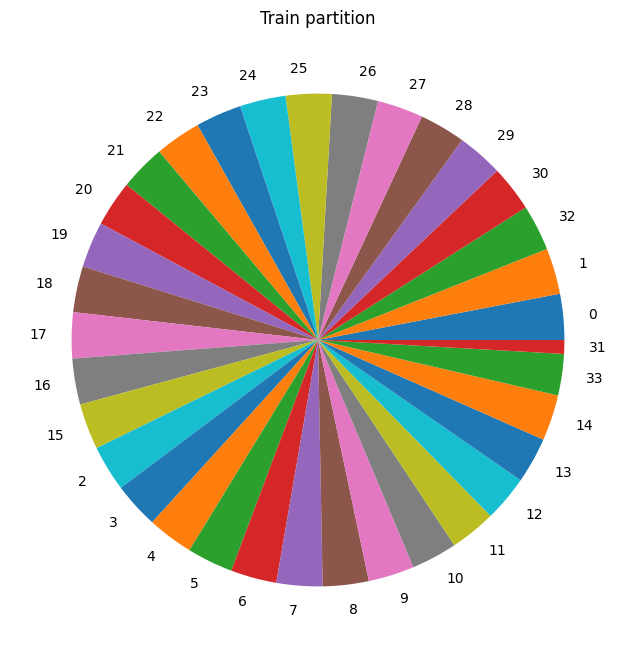

In [31]:
df_10 = df_train.groupby('labels').head(10)
df_10.labels.value_counts().plot(kind='pie', figsize=(8,8), title="Train partition", ylabel='')

<Axes: title={'center': 'Train partition'}>

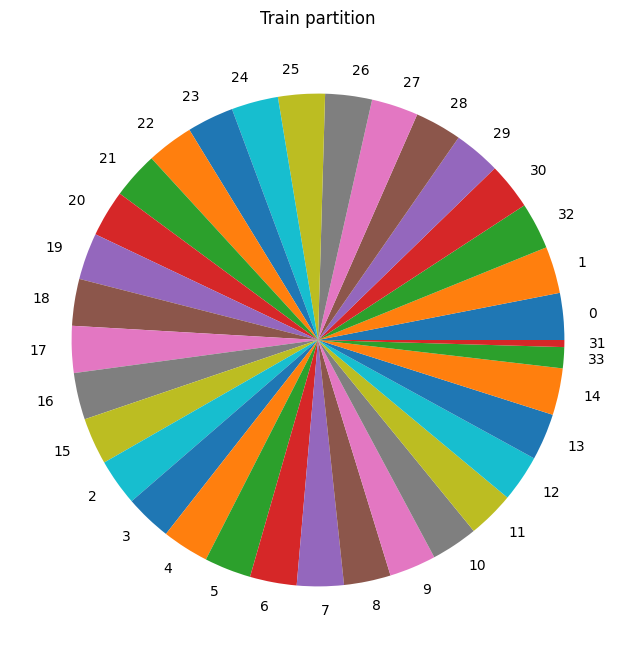

In [32]:
df_20 = df_train.groupby('labels').head(20)
df_20.labels.value_counts().plot(kind='pie', figsize=(8,8), title="Train partition", ylabel='')

#### DistilBERT 5

In [16]:
train_dataset = Dataset.from_pandas(df_5)
test_dataset = Dataset.from_pandas(df_test)
print(train_dataset)

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 168
})


In [26]:
model_ckpt='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_train = tokenized_train.remove_columns(["__index_level_0__"])

tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=1, shuffle=True, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)


Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

In [27]:

num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.to(device)
metric = load_metric("accuracy")

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    # if epoch ==4:
    #     torch.save(model, "./Pretrained/distilbertEpoch4Tasa5e-5")
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        
    model.eval()  # Establecer el modelo en modo de evaluación
    val_loss = 0.0

    with torch.no_grad():
        for val_batch in test_dataloader:
            val_batch = {k: v.to(device) for k, v in val_batch.items()}
            val_outputs = model(**val_batch)
            val_loss += val_outputs.loss.item()
            logits = val_outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            metric.add_batch(predictions=predictions, references=val_batch["labels"])

        val_acc = metric.compute()['accuracy']


    # Calcular la pérdida de validación promedio
    avg_val_loss = val_loss / len(test_dataloader)

    # Guardar los valores de pérdida
    train_losses.append(train_loss / len(train_dataloader))
    valid_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}, Training Loss: {train_loss / len(train_dataloader):.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    train_loss=0.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3360 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1, Training Loss: 3.5194, Validation Loss: 3.2755, Validation Accuracy: 0.2110
Epoch 2, Training Loss: 2.7450, Validation Loss: 2.4323, Validation Accuracy: 0.5831
Epoch 3, Training Loss: 1.6279, Validation Loss: 1.7334, Validation Accuracy: 0.6636
Epoch 4, Training Loss: 0.8729, Validation Loss: 1.2429, Validation Accuracy: 0.7818
Epoch 5, Training Loss: 0.3908, Validation Loss: 1.1506, Validation Accuracy: 0.7552
Epoch 6, Training Loss: 0.1915, Validation Loss: 1.0428, Validation Accuracy: 0.7351
Epoch 7, Training Loss: 0.1141, Validation Loss: 0.9479, Validation Accuracy: 0.7714
Epoch 8, Training Loss: 0.0843, Validation Loss: 0.9316, Validation Accuracy: 0.7656
Epoch 9, Training Loss: 0.0635, Validation Loss: 0.9143, Validation Accuracy: 0.7708
Epoch 10, Training Loss: 0.0523, Validation Loss: 0.9088, Validation Accuracy: 0.7695
Epoch 11, Training Loss: 0.0438, Validation Loss: 0.9049, Validation Accuracy: 0.7688
Epoch 12, Training Loss: 0.0368, Validation Loss: 0.9002, Valid

In [29]:

def compute_metrics(preds, labels):

    # Obtain predicted class labels by finding the column index with the maximum probability

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary

    return {
    'Accuracy': acc,
    'F1': f1,
    'Precision': precision,
    'Recall': recall
    }


In [30]:



#model = torch.load("./Pretrained/distilbertEpoch6Tasa5e-5WarmCos")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

{'Accuracy': 0.7766233766233767, 'F1': 0.7969333439112938, 'Precision': 0.8479023738777426, 'Recall': 0.7766233766233767}


/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### DistilBERT 10

In [34]:
train_dataset = Dataset.from_pandas(df_10)
test_dataset = Dataset.from_pandas(df_test)
print(train_dataset)
model_ckpt='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_train = tokenized_train.remove_columns(["__index_level_0__"])

tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=4, shuffle=True, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)


num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.to(device)
metric = load_metric("accuracy")

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    # if epoch ==4:
    #     torch.save(model, "./Pretrained/distilbertEpoch4Tasa5e-5")
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        
    model.eval()  # Establecer el modelo en modo de evaluación
    val_loss = 0.0

    with torch.no_grad():
        for val_batch in test_dataloader:
            val_batch = {k: v.to(device) for k, v in val_batch.items()}
            val_outputs = model(**val_batch)
            val_loss += val_outputs.loss.item()
            logits = val_outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            metric.add_batch(predictions=predictions, references=val_batch["labels"])

        val_acc = metric.compute()['accuracy']


    # Calcular la pérdida de validación promedio
    avg_val_loss = val_loss / len(test_dataloader)

    # Guardar los valores de pérdida
    train_losses.append(train_loss / len(train_dataloader))
    valid_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}, Training Loss: {train_loss / len(train_dataloader):.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    train_loss=0.0




#model = torch.load("./Pretrained/distilbertEpoch6Tasa5e-5WarmCos")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 332
})


Map:   0%|          | 0/332 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1660 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1, Training Loss: 3.4892, Validation Loss: 3.1452, Validation Accuracy: 0.1617
Epoch 2, Training Loss: 2.7586, Validation Loss: 2.3315, Validation Accuracy: 0.6727
Epoch 3, Training Loss: 1.6497, Validation Loss: 1.6064, Validation Accuracy: 0.7162
Epoch 4, Training Loss: 0.8195, Validation Loss: 1.2399, Validation Accuracy: 0.7188
Epoch 5, Training Loss: 0.3945, Validation Loss: 1.0577, Validation Accuracy: 0.7513
Epoch 6, Training Loss: 0.2095, Validation Loss: 1.0064, Validation Accuracy: 0.7494
Epoch 7, Training Loss: 0.1288, Validation Loss: 0.9850, Validation Accuracy: 0.7513
Epoch 8, Training Loss: 0.0923, Validation Loss: 0.9775, Validation Accuracy: 0.7519
Epoch 9, Training Loss: 0.0718, Validation Loss: 0.9681, Validation Accuracy: 0.7545
Epoch 10, Training Loss: 0.0589, Validation Loss: 0.9772, Validation Accuracy: 0.7552
Epoch 11, Training Loss: 0.0494, Validation Loss: 0.9704, Validation Accuracy: 0.7571
Epoch 12, Training Loss: 0.0416, Validation Loss: 0.9770, Valid

/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### DistilBERT 20

In [35]:
train_dataset = Dataset.from_pandas(df_20)
test_dataset = Dataset.from_pandas(df_test)
print(train_dataset)
model_ckpt='distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def preprocess_function(examples):
    return tokenizer(examples["text"],truncation=True, max_length = 512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_train = tokenized_train.remove_columns(["__index_level_0__"])

tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_test.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_train, batch_size=4, shuffle=True, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_test, batch_size=64, shuffle=False, collate_fn=data_collator)


num_labels=34
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.to(device)
metric = load_metric("accuracy")

    
progress_bar = tqdm(range(num_training_steps))
train_losses=[]
valid_losses=[]

for epoch in range(num_epochs):    
    train_loss=0.0
    model.train()
    # if epoch ==4:
    #     torch.save(model, "./Pretrained/distilbertEpoch4Tasa5e-5")
    for batch_num, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        train_loss += loss.item()

        
    model.eval()  # Establecer el modelo en modo de evaluación
    val_loss = 0.0

    with torch.no_grad():
        for val_batch in test_dataloader:
            val_batch = {k: v.to(device) for k, v in val_batch.items()}
            val_outputs = model(**val_batch)
            val_loss += val_outputs.loss.item()
            logits = val_outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            metric.add_batch(predictions=predictions, references=val_batch["labels"])

        val_acc = metric.compute()['accuracy']


    # Calcular la pérdida de validación promedio
    avg_val_loss = val_loss / len(test_dataloader)

    # Guardar los valores de pérdida
    train_losses.append(train_loss / len(train_dataloader))
    valid_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}, Training Loss: {train_loss / len(train_dataloader):.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    train_loss=0.0




#model = torch.load("./Pretrained/distilbertEpoch6Tasa5e-5WarmCos")
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

metrics = compute_metrics(all_preds, all_labels)

print(metrics)

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 652
})


Map:   0%|          | 0/652 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3260 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1, Training Loss: 3.0090, Validation Loss: 2.0683, Validation Accuracy: 0.8045
Epoch 2, Training Loss: 1.4752, Validation Loss: 1.1932, Validation Accuracy: 0.8253
Epoch 3, Training Loss: 0.6391, Validation Loss: 0.8919, Validation Accuracy: 0.8545
Epoch 4, Training Loss: 0.2876, Validation Loss: 0.8298, Validation Accuracy: 0.8494
Epoch 5, Training Loss: 0.1417, Validation Loss: 1.0369, Validation Accuracy: 0.7831
Epoch 6, Training Loss: 0.0740, Validation Loss: 0.9926, Validation Accuracy: 0.7948
Epoch 7, Training Loss: 0.0459, Validation Loss: 0.8845, Validation Accuracy: 0.8234
Epoch 8, Training Loss: 0.0295, Validation Loss: 0.9114, Validation Accuracy: 0.8214
Epoch 9, Training Loss: 0.0233, Validation Loss: 0.9269, Validation Accuracy: 0.8234
Epoch 10, Training Loss: 0.0188, Validation Loss: 0.9321, Validation Accuracy: 0.8253
Epoch 11, Training Loss: 0.0161, Validation Loss: 0.9399, Validation Accuracy: 0.8234
Epoch 12, Training Loss: 0.0140, Validation Loss: 0.9500, Valid

/home/barama/1Cuatrimestre/PLN/Proyecto/codigo/.virtual/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
